In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rnd
import scipy.stats as ss
import math
from sklearn.model_selection import train_test_split


import _pickle as cpickle
import os
import pandas_profiling

# LOADING THE DATASET

In [2]:
route = os.listdir('Datos/')

In [3]:
#Departamenos
first_route = route[0]
d_df = pd.read_csv(f'Datos/{first_route}')
                   
for i in route[1:-1]:
    tempdf = pd.read_csv(f'Datos/{i}')
    d_df = d_df.append(tempdf)

#Casas
c_df = pd.read_csv(f'Datos/{route[-1]}')

# CLEANING THE DATA AND CREATING VARIABLES

In [4]:
c_df['Tipo'] = 'Casa'
d_df['Tipo'] = 'Departamento'

In [5]:
df = d_df.append(c_df)
df.reset_index(drop = True,inplace = True)

In [6]:
def distritos_apply(x):
    a = [i.strip() for i in x.split(',')]
    x = ''
    for i in a:
        x+=i
    temp = ['Ancon','Ancón', 'Ate Vitarte','Barranco','Breña',
'Carabayllo','Chaclacayo','Chorrillos','Cieneguilla','Comas','El Agustino','Independencia','La Molina',
'Jesus Maria','Jesús María','La Victoria','Lince','Los Olivos','Lurigancho','Lurin','Lurín','Magdalena del Mar',
'Miraflores','Pachacamac','Pucusana','Pueblo Libre','Puente Piedra','Punta Hermosa','Punta Negra',
'Rimac','Rímac','San Bartolo','San Borja','San Isidro','San Juan de Lurigancho','San Juan de Miraflores',
'San Luis','San Martin de Porres','San Miguel','Santa Anita','Santa Maria del Mar','Santa María del Mar',
'Santa Rosa','Santiago de Surco','Surquillo','Villa el Salvador','Villa Maria del Triunfo','Asia','Mala','Cañete',
'Magdalena','San Martín de Porres','San Antonio','Villa María del Triunfo','Callao']
    for district in temp:
        if district.upper() in x.upper():
            return district
df['Distrito'] = df['Ubicacion'].apply(distritos_apply)

In [7]:
#CORRECTING THE REST OF THE DATA

#Squared meters
def correc_m2(x):
    return x.split('m²')[0]

#Parking
def correc_parking(x):
    if x == 'No hay informacion':
        return 1
    else:
        return x.split('Estacionamientos')[0]
#half_baths
def correc_half_baths(x):
    pass
#
def correc_dorms(x):
    a = (x.split('Dormitorios')[0])
    if a == 0:
        return 1
    else:
        return a
#
def correc_antiquy(x):
    temp = x.split('Antigüedad')
    if x == 'No hay informacion':
        return np.nan
    elif x == 'En construcciónAntigüedad':
        return 0
    elif x == 'A estrenarAntigüedad':
        return 0
    elif int(temp[0]):
        return int(temp[0])
        
#
def correc_near(x):
    
    if x == 'No hay informacion':
        return 0
    elif x != 'No hay informacion':
        return 1
#Corerct floor data
def correc_floor(x):
    import random as rnd
    if x!= 'No hay informacion':
        return int(x.split('Piso en el que se encuentra:')[1].strip())
    elif x == 'No hay informacion':
        return 5 + rnd.randint(-3,3)

#correct renatl data
def correc_alquiler(x):
    if 'S/' in x:
        return int(x.split('S/')[1].strip().replace(',',''))
    elif x == 'Consultar precio':
        return np.nan
    elif 'USD' in x:
        return 3.4*int(x.split('USD')[1].strip().replace(',',''))
    
#Correct the manteniance data
def correc_mant(x):
    if x == 'No Mantenience':
        return 1
    elif x!= 'No Mantenience':
        return float(x.replace(',',''))
    
def num_floors(x):
    if x['Tipo'] == 'Casa':
        return np.ceil(x['Dormitorios']/4)
    else:
        return np.ceil(x['Dormitorios']/3)




In [8]:
df['Antiguedad del edificio'] = df['Antiguedad del edificio'].apply(correc_antiquy) 
df['Parque cercano'] = df['Parque cercano'].apply(correc_near)
df['Mantenimiento'] = df['Mantenimiento'].apply(correc_mant)
df['Parqueo'] = df['Parqueo'].apply(correc_parking)
df['Alquiler'] = df['Alquiler'].apply(correc_alquiler)
df['Metros cuadrados'] = df['Metros cuadrados'].apply(correc_m2)
df['Metros cuadrados techados'] = df['Metros cuadrados techados'].apply(correc_m2)
df['Dormitorios'] = df['Dormitorios'].apply(correc_dorms)
df['Piso en el que se encuentra'] = df['Piso en el que se encuentra'].apply(correc_floor)

In [9]:
#Replacing values with nan (for numeric columns)
num = ['Metros cuadrados','Metros cuadrados techados','Parqueo','Dormitorios','Antiguedad del edificio',
       'Parque cercano','Piso en el que se encuentra','Alquiler','Mantenimiento']
for data in num:
    temp =  df[data].unique()
    for unique in temp:
        try:
            int(unique)
        except:
            print(f'{unique} --> {data}')
            


No hay informacion --> Metros cuadrados
No hay informacion --> Metros cuadrados techados
No hay informacion --> Dormitorios
nan --> Antiguedad del edificio
nan --> Alquiler


In [10]:
df[['Metros cuadrados','Metros cuadrados techados','Dormitorios']] = df[['Metros cuadrados','Metros cuadrados techados','Dormitorios']].replace('No hay informacion',np.nan)

In [11]:
df['Metros cuadrados'] = pd.to_numeric(df['Metros cuadrados'])
df['Metros cuadrados techados'] = pd.to_numeric(df['Metros cuadrados techados'])
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'])
df['Parqueo'] = pd.to_numeric(df['Parqueo'])


In [12]:
df['Distrito'].replace({'Rímac':'Rimac_Agust_Independen' ,'El Agustino':'Rimac_Agust_Independen', 'Independencia':'Rimac_Agust_Independen', 
            'Cieneguilla':'Cienegui_Pachacam_Lurin' , 'Pachacamac':'Cienegui_Pachacam_Lurin', 'Lurin':'Cienegui_Pachacam_Lurin', 'Lurín':'Cienegui_Pachacam_Lurin',
            'Villa el Salvador':'Chorrillos_VillaSalvador_VMT','Chorrillos':'Chorrillos_VillaSalvador_VMT','Villa María del Triunfo':'Chorrillos_VillaSalvador_VMT',
            'Jesús María':'Jesus Maria', 
           'Ancón':'Callao_Luriganch_Ancon_Carabay_PuentePie','Carabayllo':'Callao_Luriganch_Ancon_Carabay_PuentePie','Lurigancho':'Callao_Luriganch_Ancon_Carabay_PuentePie',
            'Callao':'Callao_Luriganch_Ancon_Carabay_PuentePie',
            'Puente Piedra':'Callao_Luriganch_Ancon_Carabay_PuentePie'},inplace = True)

# Null values and some variables

In [13]:
df['Alquiler'] = df['Alquiler'].fillna(1)
df['Dormitorios'] = df['Dormitorios'].fillna(1)
df[df['Dormitorios'] == 0] = 1

In [14]:
df['Numero de pisos'] = df.apply(num_floors,axis = 1)

In [15]:
#m2 techados = m2 if m2== nan
df.loc[df['Metros cuadrados'].isnull() == True,'Metros cuadrados'] = df.loc[df['Metros cuadrados'].isnull() == True,'Metros cuadrados techados']


In [16]:
df.dropna(inplace = True)

# ANALYZING  AND PREPARING DATA 

In [17]:
#Z_Score normalization
def z_normalize(df,column):
    x = df[column]
    normalized_x = (x - x.mean()/x.std()) 
    return normalized_x

#Deleting outlier rows (only for numeric data) --> The data must be normalized
def deleting_num(df,column,column2 = None):
    temp = df[np.abs(df[column]-df[column].mean()) <= (3*df[column].std())]
    return temp.reset_index(drop = True)

In [18]:
#Dropping bath and half baths columns
df.drop(axis = 1, columns = ['Baños','Medio baños','Unnamed: 0'],inplace = True)

In [19]:
df = df.drop_duplicates()

In [20]:
#Dropping the outliers of rent values
df = df[df['Mantenimiento'] < 25000]

In [21]:
#How many missing values (%)
missing = (df.isnull().sum()/len(df)) * 100
missing[missing > 0]

Series([], dtype: float64)

# DUMMY AND SPLITING

In [22]:
#Transforming categorical data (Dummy variables)
df = pd.concat([df, pd.get_dummies(df['Tipo']).iloc[:,1:]], axis = 1)
df = pd.concat([df,pd.get_dummies(df['Distrito']).iloc[:,1:]],axis = 1)

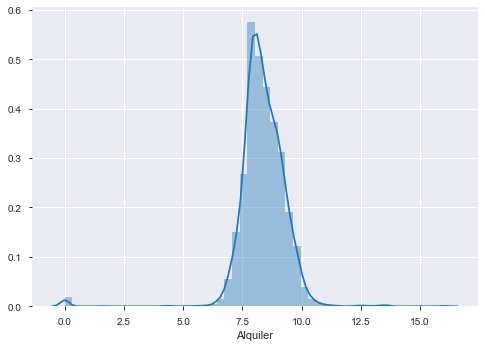

In [23]:
#Outlier detection alquiler (x_train 'alquiler ')
target = np.log(df['Alquiler'])
sns.distplot(target)
df['log_alquiler'] = target


In [24]:
#Taking out outliers
df = deleting_num(df,'log_alquiler')

In [25]:
#Separating catogrical columns and numeric columns
num_data = df.select_dtypes(include = [np.number])
cat_data = df.select_dtypes(exclude = [np.number])

In [26]:
target = num_data['log_alquiler']
del num_data['Alquiler']
del num_data['log_alquiler']


In [27]:
#Spliting the data (train-test split)     
x_train, x_test, y_train, y_test = train_test_split(num_data,target,test_size = 0.3)

# DISTRIBUTIONS

In [28]:
# #Seeing the distribution for all numeric variables
# a = pd.melt(x_train,value_vars = sorted(num_data))
# g = sns.FacetGrid(a,col = 'variable',sharex = False, sharey = False)
# g = g.map(sns.distplot, 'value')

In [29]:
#Counting data in categorical values
# def bar_plot(x_train, cols):
#     for column in cols:
#         fig = plt.figure(figsize=(7,7)) # define plot area
#         ax = fig.gca() # define axis   
#         count = x_train[column].value_counts()
#         count.plot.bar(ax = ax)
#         ax.set_title(f'variable = {column}')
#         ax.set_xlabel(column)
#         plt.show()
# bar_plot(x_train,cat_data.columns)

In [30]:
#Deleting columns of no use
# del x_train['Link Pagina']
# del x_train['Link imagen']
# del x_train['Ubicacion']


# RESCALING NUMERIC VALUES

In [31]:
"""x_train --> training sample of the numeric data. x_test --> test sample of numeric data.
Scale only on training data. For that you should split before: Only for RIDGE or LASSO regressions"""
def rescale_numeric(x_train,x_test):
    #Reescaling the numeric variables
    from sklearn.preprocessing import StandardScaler
    num_data = x_train.select_dtypes(exclude = 'uint8')
    scaler = StandardScaler().fit(num_data)
    num_data = scaler.transform(num_data)
    
    test_num_data = x_test.select_dtypes(exclude = 'uint8')
    test_num_data = scaler.transform(test_num_data)
    
    
    #Appending the dummy variables
    dummy_train = x_train.select_dtypes(include = 'uint8')
    dummy_test = x_test.select_dtypes(include = 'uint8')
    
    num_data = np.concatenate([num_data,dummy_train],axis = 1)
    test_num_data = np.concatenate([test_num_data,dummy_test],axis = 1)
    
    return num_data, test_num_data,scaler


In [32]:

def mean_absolute_percentage_error(y_true, y_pred): 
    from sklearn.utils import check_array as check_arrays
    y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 1

In [33]:
def print_metrics(y_true, y_predicted, n_parameters):
    import sklearn.metrics as sklm
    import math

    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))


In [34]:
def press_statistic(y_true, y_pred, xs):
    """
    Calculation of the `Press Statistics <https://www.otexts.org/1580>`_
    """
    res = y_pred - y_true
    hat = xs.dot(np.linalg.pinv(xs))
    den = (1 - np.diagonal(hat))
    sqr = np.square(res/den)
    return sqr.sum()

def predicted_r2(y_true, y_pred, xs):
    """
    Calculation of the `Predicted R-squared <https://rpubs.com/RatherBit/102428>`_
    """
    press = press_statistic(y_true=y_true,
                            y_pred=y_pred,
                            xs=xs
    )

    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - press / sst
 
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

# LINEAR REGRESSION

In [35]:
#LINEAR MODEL
from sklearn import linear_model
lin_model = linear_model.LinearRegression(fit_intercept = True)
lin_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
#TRAINING METRICS
y_training_lr = lin_model.predict(x_train)
print_metrics(y_train,y_training_lr,46)

Mean Square Error      = 0.13849423335662142
Root Mean Square Error = 0.37214813361969373
Mean Absolute Error    = 0.25492860957979435
Median Absolute Error  = 0.1885794650491981
R^2                    = 0.7438172239612191
Adjusted R^2           = 0.7410359875506654


In [37]:
#TESTING METRICS
y_score = lin_model.predict(x_test) 
print_metrics(y_test,y_score,47)

Mean Square Error      = 0.15744036529736333
Root Mean Square Error = 0.3967875568832311
Mean Absolute Error    = 0.2708554357064538
Median Absolute Error  = 0.19444516457578054
R^2                    = 0.7266313731347049
Adjusted R^2           = 0.7194456835142458


# LASSO REGRESSION

In [38]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso_regressor=Lasso(alpha = 1e-15)
lasso_regressor.fit(x_train,y_train)

# parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
# lasso_regressor=GridSearchCV(lasso,parameters,cv=7)

# print(lasso_regressor.best_params_)
#print(lasso_regressor.best_score_)

c:\users\diego\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.78045788503658, tolerance: 0.22656844498778297
  positive)


Lasso(alpha=1e-15, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
#TRAINING METRICS
y_training_lassor = lasso_regressor.predict(x_train)
print_metrics(y_train,y_training_lassor,44)

Mean Square Error      = 0.13849423335662142
Root Mean Square Error = 0.37214813361969373
Mean Absolute Error    = 0.2549286095797902
Median Absolute Error  = 0.1885794650490631
R^2                    = 0.7438172239612191
Adjusted R^2           = 0.7411608797679065


In [48]:
lasso_regressor

Lasso(alpha=1e-15, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
#TEST METRICS
y_lasso = lasso_regressor.predict(x_test)
print_metrics(y_test,y_lasso,44)

Mean Square Error      = 0.15744036529730562
Root Mean Square Error = 0.39678755688315837
Mean Absolute Error    = 0.27085543570643456
Median Absolute Error  = 0.19444516457576277
R^2                    = 0.7266313731348051
Adjusted R^2           = 0.7199258106960125


In [51]:
#GOING WITH LASSO REGRESSION
# cpickle.dump(lasso_regressor,open('outputs/lasso.pkl','wb'))

# RIDGE REGRESSION 

In [41]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=10)
ridge_regressor.fit(x_train,y_train)

c:\users\diego\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.50885e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\diego\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.64873e-25): result may not be accurate.
  overwrite_a=True).T
c:\users\diego\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.67359e-20): result may not be accurate.
  overwrite_a=True).T
c:\users\diego\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.42681e-20): result may not be accurate.
  overwrite_a=True).T
c:\users\diego\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-condi

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [42]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 1}
-0.1609289487289635


In [43]:
#TRAINING METRICS
y_training_ridge = ridge_regressor.predict(x_train)
print_metrics(y_train,y_training_ridge,47)

Mean Square Error      = 0.1387734788494431
Root Mean Square Error = 0.37252312525458486
Mean Absolute Error    = 0.2550092131103154
Median Absolute Error  = 0.18728846568457058
R^2                    = 0.7433006834251004
Adjusted R^2           = 0.7404512218994137


In [44]:
#TESTING METRICS
y_ridge = ridge_regressor.predict(x_test)
print_metrics(y_test,y_ridge,47)

Mean Square Error      = 0.15609443977949808
Root Mean Square Error = 0.39508788867731454
Mean Absolute Error    = 0.27023970658529917
Median Absolute Error  = 0.19364052725649827
R^2                    = 0.7289683456765741
Adjusted R^2           = 0.7218440850486441


GOING WITH LASSO REGRESSION

In [45]:
lasso_coefs = pd.DataFrame(x_train.columns)
lasso_coefs = lasso_coefs.transpose()


In [46]:
temp = np.vstack((lasso_coefs,lasso_regressor.coef_))
lasso_coefs = pd.DataFrame(temp,columns = temp[0]).iloc[1:,:]


In [47]:
# lasso_coefs.to_csv('outputs/lasso_coeficients.csv')

In [63]:
x_test.iloc[1317]

Metros cuadrados                             68.0
Metros cuadrados techados                    68.0
Parqueo                                       1.0
Dormitorios                                   1.0
Antiguedad del edificio                       8.0
Parque cercano                                1.0
Piso en el que se encuentra                   8.0
Mantenimiento                               260.0
Numero de pisos                               1.0
Casa                                          0.0
Departamento                                  1.0
Asia                                          0.0
Ate Vitarte                                   0.0
Barranco                                      0.0
Breña                                         0.0
Callao_Luriganch_Ancon_Carabay_PuentePie      0.0
Cañete                                        0.0
Chaclacayo                                    0.0
Chorrillos_VillaSalvador_VMT                  0.0
Cienegui_Pachacam_Lurin                       0.0


In [65]:
y_test

1415    7.600902
1317    8.445912
5640    9.384294
2940    7.816014
2569    7.003065
          ...   
4374    7.661056
3040    9.301643
1935    9.611797
5707    9.740969
4731    8.226841
Name: log_alquiler, Length: 1797, dtype: float64